### https://arxiv.org/pdf/2402.08593

In [6]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, RocCurveDisplay

from sklearn.preprocessing import normalize

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd
import xgboost as xgb

import settings as s

assert s.FILE_SIZE == "Medium"
assert s.HIGH_ILLICIT == True

os.environ["EXT_DATA_TYPE_FOLDER"] = s.OUTPUT_POSTFIX.lstrip("-")

from common import get_weights, delete_large_vars, MULTI_PROC_STAGING_LOCATION
from communities import get_communities_spark
from features import (
    generate_features_spark, generate_features_udf_wrapper, get_edge_features_udf,
    SCHEMA_FEAT_UDF, CURRENCY_RATES
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
start_script = time.time()

In [8]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [9]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/31 16:03:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
TRAIN_PERC = 0.6
VALIDATION_PERC = 0.2
TEST_PERC = 0.2

KEEP_TOP_N = 100

assert(sum([TRAIN_PERC, VALIDATION_PERC, TEST_PERC]) == 1)

location_main = os.path.join("features", os.environ["EXT_DATA_TYPE_FOLDER"])
# shutil.rmtree(location_main, ignore_errors=True)

location_communities_leiden = f"{location_main}{os.sep}communities_leiden.parquet"

location_features_leiden = f"{location_main}{os.sep}features_leiden.parquet"
location_features_ego = f"{location_main}{os.sep}features_ego.parquet"
location_features_2_hop = f"{location_main}{os.sep}features_2_hop.parquet"
location_features_2_hop_out = f"{location_main}{os.sep}features_2_hop_out.parquet"
location_features_2_hop_in = f"{location_main}{os.sep}features_2_hop_in.parquet"
location_features_2_hop_combined = f"{location_main}{os.sep}features_2_hop_combined.parquet"
location_features_source = f"{location_main}{os.sep}features_source.parquet"
location_features_target = f"{location_main}{os.sep}features_target.parquet"

location_flow_dispense = f"{location_main}{os.sep}location_flow_dispense.parquet"
location_flow_passthrough = f"{location_main}{os.sep}location_flow_passthrough.parquet"
location_flow_sink = f"{location_main}{os.sep}location_flow_sink.parquet"

location_comm_as_source_features = f"{location_main}{os.sep}comm_as_source_features.parquet"
location_comm_as_target_features = f"{location_main}{os.sep}comm_as_target_features.parquet"
location_comm_as_passthrough_features = f"{location_main}{os.sep}comm_as_passthrough_features.parquet"
location_comm_as_passthrough_features_reverse = f"{location_main}{os.sep}comm_as_passthrough_features_reverse.parquet"

location_features_node_level = f"{location_main}{os.sep}features_node_level.parquet"
location_features_edges = f"{location_main}{os.sep}features_edges.parquet"

location_features_edges_train = f"{location_main}{os.sep}features_edges_train.parquet"
location_features_edges_valid = f"{location_main}{os.sep}features_edges_valid.parquet"
location_features_edges_test = f"{location_main}{os.sep}features_edges_test.parquet"

location_train_trx_features = f"{location_main}{os.sep}train_trx_features.parquet"
location_valid_trx_features = f"{location_main}{os.sep}valid_trx_features.parquet"
location_test_trx_features = f"{location_main}{os.sep}test_trx_features.parquet"

location_train_features = f"{location_main}{os.sep}train_features.parquet"
location_valid_features = f"{location_main}{os.sep}valid_features.parquet"
location_test_features = f"{location_main}{os.sep}test_features.parquet"

try:
    os.makedirs(location_main)
except FileExistsError:
    pass

In [11]:
data = spark.read.parquet(s.STAGED_DATA_LOCATION)
data = data.withColumn("is_laundering", sf.col("is_laundering").cast("boolean"))
data_count_original = data.count()

In [7]:
%%time

trx_ids_sorted = data.sort("timestamp").select("transaction_id").toPandas()["transaction_id"].values
trx_count = len(trx_ids_sorted)

last_train_index = int(np.floor(trx_count * TRAIN_PERC))
last_validation_index = last_train_index + int(np.floor(trx_count * VALIDATION_PERC))
train_indexes = trx_ids_sorted[:last_train_index]
validation_indexes = trx_ids_sorted[last_train_index:last_validation_index]
test_indexes = trx_ids_sorted[last_validation_index:]

train_indexes = spark.createDataFrame(
    pd.DataFrame(train_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)
validation_indexes = spark.createDataFrame(
    pd.DataFrame(validation_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)
test_indexes = spark.createDataFrame(
    pd.DataFrame(test_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)

train = train_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
validation = validation_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
test = test_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
train_count, validation_count, test_count = train.count(), validation.count(), test.count()
print()
print(trx_count, train_count, validation_count, test_count)
print()

25/07/31 14:03:45 WARN TaskSetManager: Stage 21 contains a task of very large size (17125 KiB). The maximum recommended task size is 1000 KiB.
25/07/31 14:03:50 WARN TaskSetManager: Stage 23 contains a task of very large size (17125 KiB). The maximum recommended task size is 1000 KiB.
25/07/31 14:03:56 WARN TaskSetManager: Stage 34 contains a task of very large size (17125 KiB). The maximum recommended task size is 1000 KiB.
25/07/31 14:04:01 WARN TaskSetManager: Stage 36 contains a task of very large size (17125 KiB). The maximum recommended task size is 1000 KiB.
[Stage 39:=====================================================>(199 + 1) / 200]


31867069 19120241 6373413 6373415

CPU times: user 445 ms, sys: 173 ms, total: 618 ms
Wall time: 2min 42s


In [8]:
%%time

edges = data.groupby(["source", "target"]).agg(
    sf.sum("amount").alias("amount")
).toPandas()
weights = get_weights(edges)
edges_agg = edges.set_index(["source", "target"]).join(
    weights.set_index(["source", "target"]), how="left"
).reset_index()
edges_agg.loc[:, "amount_weighted"] = (
    edges_agg.loc[:, "amount"] * 
    (edges_agg.loc[:, "weight"] / edges_agg.loc[:, "weight"].max())
)

CPU times: user 34.2 s, sys: 920 ms, total: 35.1 s
Wall time: 40.7 s


In [9]:
# Later on, we will reset the variables (to free up memory), while still keeping these intact
to_keep = %who_ls
to_keep = list(to_keep)

In [10]:
%%time

TOP_N = 50
NUM_HOPS = 5

data_input = spark.createDataFrame(edges_agg)
nodes_source = set(edges_agg["source"].unique())
nodes_target = set(edges_agg["target"].unique())
nodes_passthrough = nodes_source.intersection(nodes_target)

%run generate_flow_features.ipynb

comm_as_source_features.to_parquet(location_comm_as_source_features)
comm_as_target_features.to_parquet(location_comm_as_target_features)
comm_as_passthrough_features.to_parquet(location_comm_as_passthrough_features)
comm_as_passthrough_features_reverse.to_parquet(location_comm_as_passthrough_features_reverse)

del comm_as_source_features
del comm_as_target_features
del comm_as_passthrough_features
del comm_as_passthrough_features_reverse


Processing comm_as_source

Processed hop #1 | 2,842,770 | 1,333,420
Processed hop #2 | 4,358,267 | 847,080
Processed hop #3 | 6,468,686 | 661,588
Processed hop #4 | 8,492,595 | 593,472
Processed hop #5 | 10,225,029 | 556,876

Processing comm_as_target

Processed hop #1 | 2,967,961 | 1,169,331
Processed hop #2 | 11,502,196 | 963,178
Processed hop #3 | 15,539,582 | 919,379
Processed hop #4 | 20,255,707 | 894,218
Processed hop #5 | 23,799,812 | 882,995

Processing comm_as_passthrough

Processed hop #1 | 2,405,456 | 949,800
Processed hop #2 | 3,599,750 | 608,779
Processed hop #3 | 5,394,064 | 508,228
Processed hop #4 | 6,981,617 | 456,019
Processed hop #5 | 8,250,246 | 427,327

Processing comm_as_passthrough_reverse

Processed hop #1 | 2,811,504 | 1,108,680
Processed hop #2 | 10,885,590 | 912,988
Processed hop #3 | 14,752,721 | 870,883
Processed hop #4 | 19,343,674 | 846,994
Processed hop #5 | 22,862,561 | 836,186


comm_as_source_features

CPU times: user 1min 52s, sys: 886 ms, total: 1m

In [11]:
%%time

print("Constructing Leiden communities")

graph = ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_weighted"]], use_vids=False, directed=True)
nodes_mapping = {x.index: x["name"] for x in graph.vs()}
communities_leiden = la.find_partition(
    graph, la.ModularityVertexPartition, n_iterations=100, weights="amount_weighted"
)
communities_leiden = [[nodes_mapping[_] for _ in x] for x in communities_leiden]
communities_leiden = [(str(uuid.uuid4()), set(x)) for x in communities_leiden]
sizes_leiden = [len(x[1]) for x in communities_leiden]

with open(location_communities_leiden, "wb") as fl:
    pickle.dump(communities_leiden, fl)

Constructing Leiden communities
CPU times: user 51min 5s, sys: 28.6 s, total: 51min 34s
Wall time: 51min 29s


In [12]:
# with open(location_communities_leiden, "rb") as fl:
#     communities_leiden = pickle.load(fl)

In [13]:
%%time

data_agg_weights = get_weights(
    data.groupby(["source", "target"])
    .agg(
        sf.sum("amount").alias("amount")
    ).toPandas()
)

data_agg_weights_rev = data_agg_weights.rename(
    columns={"target": "source", "source": "target"}
).loc[:, ["source", "target", "weight"]]
data_agg_weights_ud = pd.concat([data_agg_weights, data_agg_weights_rev], ignore_index=True)
data_agg_weights_ud = data_agg_weights_ud.groupby(["source", "target"]).agg(weight=("weight", "sum")).reset_index()

data_agg_weights_ud.sort_values("weight", ascending=False, inplace=True)
grouped_ud = data_agg_weights_ud.groupby("source").head(KEEP_TOP_N).reset_index(drop=True)
grouped_ud = grouped_ud.groupby("source").agg(targets=("target", set))

total = grouped_ud.index.nunique()
nodes_neighborhoods = {}
for index, (source, targets) in enumerate(grouped_ud.iterrows()):
    community_candidates = {source}
    for target in targets["targets"]:
        community_candidates |= (grouped_ud.loc[target, "targets"] | {target})
    nodes_neighborhoods[source] = set(community_candidates)
    if not (index % 250_000):
        print(index, total)

del data_agg_weights_rev
del data_agg_weights_ud
del grouped_ud

0 2070952
250000 2070952
500000 2070952
750000 2070952
1000000 2070952
1250000 2070952
1500000 2070952
1750000 2070952
2000000 2070952
CPU times: user 1min 46s, sys: 1.41 s, total: 1min 47s
Wall time: 1min 52s


In [14]:
%%time

print("Constructing 2-hop communities")

communities_2_hop = get_communities_spark(
    nodes_neighborhoods,
    ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_weighted"]], use_vids=False, directed=True), 
    os.cpu_count(), spark, 2, "all", 0.01, "amount_weighted"
)
sizes_2_hop = [len(x[1]) for x in communities_2_hop]

Constructing 2-hop communities


CPU times: user 24.8 s, sys: 1.5 s, total: 26.3 s
Wall time: 5min 48s


In [15]:
%%time

ts_min = data.select(sf.min("timestamp").alias("x")).collect()[0]["x"] - timedelta(minutes=1)
data_graph_agg = data.groupby(["source", "target", "source_bank", "target_bank", "source_currency"]).agg(
    sf.count("source").alias("num_transactions"),
    sf.sum("amount").alias("amount"),
    sf.sum("source_amount").alias("source_amount"),
    sf.collect_list(sf.array((sf.col("timestamp") - ts_min).cast("long"), sf.col("amount"))).alias("timestamps_amounts"),
)
data_graph_agg_sdf = data_graph_agg.persist(StorageLevel.DISK_ONLY)
print(data_graph_agg_sdf.count())
data_graph_agg = data_graph_agg_sdf.toPandas()
index = ["source", "target"]
edges_agg.loc[:, index + ["weight"]].set_index(index)
data_graph_agg = data_graph_agg.set_index(index).join(
    edges_agg.loc[:, index + ["weight"]].set_index(index), how="left"
).reset_index()
data_graph_agg.loc[:, "amount_weighted"] = (
    data_graph_agg.loc[:, "amount"] * 
    (data_graph_agg.loc[:, "weight"] / data_graph_agg.loc[:, "weight"].max())
)

4476472


CPU times: user 37.2 s, sys: 3.48 s, total: 40.7 s
Wall time: 1min 23s


In [16]:
graph = ig.Graph.DataFrame(data_graph_agg, use_vids=False, directed=True)

In [17]:
%%time

print("Leiden communitites features creation")

features_leiden = generate_features_spark(communities_leiden, graph, spark)
features_leiden = features_leiden.rename(columns={"key": "key_fake"})
communities_leiden_dict = dict(communities_leiden)
features_leiden.loc[:, "key"] = features_leiden.loc[:, "key_fake"].apply(lambda x: communities_leiden_dict[x])
features_leiden = features_leiden.explode("key")
del features_leiden["key_fake"]
features_leiden.set_index("key").to_parquet(location_features_leiden)

Leiden communitites features creation


CPU times: user 4min 20s, sys: 23.7 s, total: 4min 44s
Wall time: 11min 52s


In [18]:
%%time

print("2-hop communitites features creation")

features_2_hop = generate_features_spark(communities_2_hop, graph, spark)
features_2_hop.set_index("key").to_parquet(location_features_2_hop)

2-hop communitites features creation


CPU times: user 23min 49s, sys: 16min 6s, total: 39min 56s
Wall time: 1h 10min 43s


In [19]:
del graph

In [20]:
%%time

print("Temporal flows features creation")

edges_totals = data.select("source", "target", "amount").groupby(
    ["source", "target"]
).agg(sf.count("amount").alias("amount")).toPandas()
edges_totals = edges_totals.sort_values("amount", ascending=False).reset_index(drop=True)
left_edges = spark.createDataFrame(edges_totals.groupby("target").head(TOP_N).loc[:, ["source", "target"]])
right_edges = spark.createDataFrame(edges_totals.groupby("source").head(TOP_N).loc[:, ["source", "target"]])

columns = ["source", "target", "timestamp", "amount"]

left = left_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)
select = []
for column in left.columns:
    select.append(sf.col(column).alias(f"left_{column}"))
left = left.select(*select)
right = right_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)

print(left.count(), right.count())

flows_temporal = left.join(
    right,
    (left["left_target"] == right["source"]) &
    (left["left_timestamp"] <= right["timestamp"]),
    how="inner"
).groupby(["left_source", "left_target", "source", "target"]).agg(
    sf.sum("left_amount").alias("left_amount"),
    sf.sum("amount").alias("amount"),
).drop("left_target").select(
    sf.col("left_source").alias("dispense"),
    sf.col("source").alias("passthrough"),
    sf.col("target").alias("sink"),
    sf.least("left_amount", "amount").alias("amount"),
)

aggregate = [
    sf.sum("amount").alias("amount_sum"),
    sf.mean("amount").alias("amount_mean"),
    sf.median("amount").alias("amount_median"),
    sf.max("amount").alias("amount_max"),
    sf.stddev("amount").alias("amount_std"),
    sf.countDistinct("dispense").alias("dispense_count"),
    sf.countDistinct("passthrough").alias("passthrough_count"),
    sf.countDistinct("sink").alias("sink_count"),
]
for flow_location, flow_type in [
    (location_flow_dispense, "dispense"), (location_flow_passthrough, "passthrough"), (location_flow_sink, "sink")
]:
    print(flow_type)
    flows_temporal_stats = flows_temporal.groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_cyclic_stats = flows_temporal.where(
        (sf.col("dispense") == sf.col("sink"))
    ).groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_stats = flows_temporal_stats.set_index(flow_type).join(
        flows_temporal_cyclic_stats.set_index(flow_type),
        how="left", rsuffix="_cycle"
    )
    flows_temporal_stats.index.name = "key"
    flows_temporal_stats.to_parquet(flow_location)
    del flows_temporal_stats
    del flows_temporal_cyclic_stats

left.unpersist()
right.unpersist()

del edges_totals
del left_edges
del right_edges

Temporal flows features creation


31827307 28952152
dispense


passthrough


sink


CPU times: user 14.2 s, sys: 2.58 s, total: 16.7 s
Wall time: 9min 12s


In [21]:
%%time

print("1-hop-source features creation")

features_source = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("source")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_source = pd.DataFrame(features_source["features"].apply(json.loads).tolist())
features_source.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_source.columns]
features_source.set_index("key").to_parquet(location_features_source)

1-hop-source features creation


25/07/31 03:20:02 WARN TaskSetManager: Stage 285 contains a task of very large size (2896 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1min 43s, sys: 12.7 s, total: 1min 56s
Wall time: 25min 3s


In [22]:
%%time

print("1-hop-target features creation")

features_target = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("target")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_target = pd.DataFrame(features_target["features"].apply(json.loads).tolist())
features_target.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_target.columns]
features_target.set_index("key").to_parquet(location_features_target)

1-hop-target features creation


25/07/31 03:44:58 WARN TaskSetManager: Stage 288 contains a task of very large size (2896 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1min 41s, sys: 8.72 s, total: 1min 50s
Wall time: 20min 27s


In [23]:
del data_graph_agg

In [24]:
ENABLED_FEATURES = [
    ("leiden", location_features_leiden),
    ("2_hop", location_features_2_hop),
    ("as_source", location_features_source),
    ("as_target", location_features_target),
    ("comm_as_source_features", location_comm_as_source_features),
    ("comm_as_target_features", location_comm_as_target_features),
    ("comm_as_passthrough_features", location_comm_as_passthrough_features),
    ("comm_as_passthrough_features_reverse", location_comm_as_passthrough_features_reverse),
    ("flow_dispense", location_flow_dispense),
    ("flow_passthrough", location_flow_passthrough),
    ("flow_sink", location_flow_sink),   
]

In [25]:
all_features = pd.DataFrame()
all_features.index.name = "key"

for feature_group, location in ENABLED_FEATURES:
    all_features = all_features.join(
        pd.read_parquet(location), how="outer", rsuffix=f"_{feature_group}"
    )

all_features.to_parquet(location_features_node_level)
print("Features:", all_features.shape)
del all_features

Features: (2070952, 344)


In [29]:
all_features = pd.read_parquet(location_features_node_level)

In [31]:
all_features.shape

(2070952, 344)

In [32]:
constants = []
for column in all_features.columns:
    if all_features[column].nunique(dropna=True) <= 1:
        del all_features[column]
        constants.append(column)
print(f"Deleted {len(constants)} constant columns")

Deleted 14 constant columns


In [33]:
medians = {}
for column in all_features.columns:
    medians[column] = np.nanmedian(all_features[column])

In [34]:
delta = round(time.time() - start_script)
print(f"Script executed in {timedelta(seconds=delta)}")

Script executed in 0:29:29


In [35]:
%%time

print("Training the anomaly detection model")

anomalies = all_features.loc[:, []]
model_ad = IsolationForest(n_estimators=10_000)
anomalies.loc[:, "anomaly_score"] = -model_ad.fit(
    all_features.fillna(medians)
).decision_function(all_features.fillna(medians))
anomalies.loc[:, "anomaly_score"] += abs(anomalies.loc[:, "anomaly_score"].min()) + 1e-10
anomalies.loc[:, "anomaly_score"] /= anomalies.loc[:, "anomaly_score"].max()

Training the anomaly detection model
CPU times: user 7.25 s, sys: 8.09 s, total: 15.3 s
Wall time: 18.1 s


In [32]:
n_components = 50
pca = PCA(n_components=n_components)
all_features_dim_reduced = pd.DataFrame(
    pca.fit_transform(normalize(all_features.fillna(medians), norm="l1", axis=1)),
    index=all_features.index
)
explained_variance_ratio = round(sum(pca.explained_variance_ratio_) * 100, 2)
assert explained_variance_ratio > 99
print(n_components, explained_variance_ratio)
all_features_dim_reduced.columns = [
    f"pca_{x + 1}" for x in all_features_dim_reduced.columns
]
all_features_dim_reduced = all_features_dim_reduced.astype(np.float32)

50 99.99


In [33]:
%%time

print(f"Generating edge features")

to_select = ["source", "target", "format", "source_currency", "source_amount", "amount", "timestamp"]

edges_features_input = data.select(to_select).groupby(
    ["source", "target", "format", "source_currency"]
).agg(
    sf.sum("source_amount").alias("source_amount"), 
    sf.sum("amount").alias("amount"),
    sf.unix_timestamp(sf.min("timestamp")).alias("min_ts"),
    sf.unix_timestamp(sf.max("timestamp")).alias("max_ts"),
).repartition(os.cpu_count() * 2, "source", "target").persist(StorageLevel.DISK_ONLY)
_ = edges_features_input.count()

edge_features = edges_features_input.groupby(["source", "target"]).applyInPandas(
    get_edge_features_udf, schema=SCHEMA_FEAT_UDF
).toPandas()
edge_features = pd.DataFrame(edge_features["features"].apply(json.loads).tolist())

edge_features.to_parquet(location_features_edges)
del edge_features

Generating edge features


CPU times: user 15 s, sys: 2.83 s, total: 17.9 s
Wall time: 12min 9s


In [8]:
edge_features = pd.read_parquet(location_features_edges)

In [27]:
%%time

train_edges = train.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)
valid_edges = validation.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)
test_edges = test.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)

train_features = train_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
validation_features = valid_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
test_features = test_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()

CPU times: user 22.2 s, sys: 2.03 s, total: 24.2 s
Wall time: 1min 16s


In [92]:
all_features_spark = spark.createDataFrame(all_features.reset_index())
for col in all_features_spark.columns:
    all_features_spark = all_features_spark.withColumnRenamed(col, f"node_{col}")

In [115]:
def save_edge_features(features_in, location):
    initial_node_features = list(all_features_spark.columns)

    features_in = features_in.rename(
        columns={x: f"edge_{x}" for x in features_in.columns}
    )
    features_in = features_in.set_index("edge_target").join(
        anomalies, how="left"
    ).reset_index().set_index("edge_source").join(
        anomalies, how="left", rsuffix="_source"
    ).reset_index()
    
    features_in = spark.createDataFrame(features_in)
    features_in = features_in.withColumnRenamed("anomaly_score", "anomaly_score_target")
    
    features_in = features_in.join(
        all_features_spark,
        features_in["edge_source"] == all_features_spark["node_key"],
        how="left"
    )

    all_features_spark_target = all_features_spark.select(*initial_node_features)
    for col in all_features_spark_target.columns:
        all_features_spark_target = all_features_spark_target.withColumnRenamed(col, f"{col}_target")

    features_in = features_in.join(
        all_features_spark_target,
        features_in["edge_target"] == all_features_spark_target["node_key_target"],
        how="left"
    )

    features_in = features_in.withColumnRenamed("edge_source", "source")
    features_in = features_in.withColumnRenamed("edge_target", "target").drop("node_key", "node_key_target")

    features_in = features_in.withColumn(
        "anom_scores_diff", sf.col("anomaly_score_source") - sf.col("anomaly_score_target")
    )
    features_in = features_in.withColumn(
        "anom_scores_min", sf.least(sf.col("anomaly_score_source"), sf.col("anomaly_score_target"))
    )
    features_in = features_in.withColumn(
        "anom_scores_max", sf.greatest(sf.col("anomaly_score_source"), sf.col("anomaly_score_target"))
    )
    features_in = features_in.withColumn(
        "anom_scores_mean", (sf.col("anomaly_score_source") + sf.col("anomaly_score_target")) / 2
    )
    features_in.write.parquet(location, mode="overwrite")

In [117]:
%%time

save_edge_features(train_features, location_features_edges_train)

25/07/31 15:28:35 WARN TaskSetManager: Stage 106 contains a task of very large size (26215 KiB). The maximum recommended task size is 1000 KiB.
25/07/31 15:28:52 WARN TaskSetManager: Stage 107 contains a task of very large size (2303 KiB). The maximum recommended task size is 1000 KiB.
[Stage 114:====================================================>(104 + 1) / 105]

CPU times: user 7 s, sys: 1.63 s, total: 8.62 s
Wall time: 2min 32s


In [116]:
%%time

save_edge_features(validation_features, location_features_edges_valid)

25/07/31 15:26:53 WARN TaskSetManager: Stage 97 contains a task of very large size (26215 KiB). The maximum recommended task size is 1000 KiB.
25/07/31 15:27:08 WARN TaskSetManager: Stage 98 contains a task of very large size (2303 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

In [118]:
%%time

save_edge_features(test_features, location_features_edges_test)

25/07/31 15:31:11 WARN TaskSetManager: Stage 115 contains a task of very large size (26215 KiB). The maximum recommended task size is 1000 KiB.
25/07/31 15:31:27 WARN TaskSetManager: Stage 116 contains a task of very large size (2303 KiB). The maximum recommended task size is 1000 KiB.
[Stage 123:==================================================>    (61 + 6) / 67]

CPU times: user 3.12 s, sys: 826 ms, total: 3.95 s
Wall time: 1min 31s


In [40]:
def save_trx_features(data_in, location):
    columns = ["source", "target", "source_currency", "target_currency", "format", "amount", "is_laundering"]
    
    trx_features = data_in.select(*columns).toPandas()
    trx_features.loc[:, "inter_currency"] = trx_features["source_currency"] != trx_features["target_currency"]

    trx_features.to_parquet(location)
    del trx_features

In [41]:
%%time

save_trx_features(train, location_train_trx_features)
save_trx_features(validation, location_valid_trx_features)
save_trx_features(test, location_test_trx_features)

CPU times: user 15 s, sys: 1.78 s, total: 16.8 s
Wall time: 22.2 s


In [42]:
# To free up memory for training

to_reset = %who_ls
to_reset = list(to_reset)
to_reset.remove("to_keep")
to_reset = set(to_reset) - set(to_keep)
for var_to_reset in list(to_reset):
    var_to_reset = f"^{var_to_reset}$"
    %reset_selective -f {var_to_reset}

delete_large_vars(globals(), locals())

Deleted `global` DataFrame: edges
Deleted `global` DataFrame: weights
Deleted `global` DataFrame: edges_agg


True

In [124]:
def combine_features(location_features_trx, location_features_edges, location_features):
    features_input = spark.read.parquet(location_features_edges)
    trx_features_input = spark.read.parquet(location_features_trx).withColumnRenamed(
        "source", "source_trx"
    ).withColumnRenamed(
        "target", "target_trx"
    )
    features_input = trx_features_input.join(
        features_input,
        (trx_features_input["source_trx"] == features_input["source"]) &
        (trx_features_input["target_trx"] == features_input["target"]),
        how="left"
    ).drop("source_trx", "target_trx", "source", "target")
    features_input = features_input.write.parquet(location_features, mode="overwrite")

In [125]:
%%time

combine_features(location_train_trx_features, location_features_edges_train, location_train_features)
combine_features(location_valid_trx_features, location_features_edges_valid, location_valid_features)
combine_features(location_test_trx_features, location_features_edges_test, location_test_features)

CPU times: user 268 ms, sys: 233 ms, total: 501 ms
Wall time: 7min 46s


In [126]:
shutil.rmtree(MULTI_PROC_STAGING_LOCATION, ignore_errors=True)

In [12]:
category_features = ["source_currency", "target_currency", "format"]
category_features_map = {}
for feat in category_features:
    dist_vals = data.select(feat).distinct().toPandas()
    category_features_map[feat] = dict(zip(dist_vals[feat], dist_vals.index))

In [13]:
def conv_dataframe_for_libsvm(df_input):
    columns = list(df_input.columns)
    columns.remove("is_laundering")
    columns = ["is_laundering"] + columns
    df_input = df_input.loc[:, columns]
    new_types = {}
    feature_types = []
    for col, dtype in zip(df_input.columns, df_input.dtypes):
        if col in category_features:
            feature_types.append("c")
        elif dtype == bool:
            new_types[col] = np.uint8
            feature_types.append("i")
        elif str(dtype).startswith("float"):
            feature_types.append("q")
        elif str(dtype).startswith("int"):
            feature_types.append("int")
        else:
            raise
    df_input = df_input.astype(new_types)
    for col, mapping in category_features_map.items():
        new_col = f"tmp_{col}"
        df_input = df_input.copy()
        df_input.loc[:, new_col] = df_input.loc[:, col].apply(lambda x: mapping[x])
        del df_input[col]
        df_input = df_input.rename(columns={new_col: col})
    return df_input.loc[:, columns], columns[1:], feature_types[1:]

In [23]:
%%time

feature_columns, feature_types = [], []
for name, feat_loc in [
    ("train", location_train_features),
    ("valid", location_valid_features),
    ("test", location_test_features),
]:
    print("=" * 50)
    print(feat_loc)
    print("=" * 50)
    part_files = glob(f"{feat_loc}{os.sep}part*parquet")
    total = len(part_files)
    mode, header = "w", True
    for index, fl in enumerate(part_files):
        if not (index % 10):
            print(index + 1, total)
        part = pd.read_parquet(fl)
        part, feature_columns, feature_types = conv_dataframe_for_libsvm(part)
        part.to_csv(f"{location_main}{os.sep}{name}.csv", index=False, mode=mode, header=header)
        mode, header = "a", False
    shutil.rmtree(feat_loc, ignore_errors=True)

features/hi-medium/train_features.parquet
1 200
11 200
CPU times: user 3min 5s, sys: 7.81 s, total: 3min 12s
Wall time: 3min 9s


In [19]:
dtrain = xgb.DMatrix(
    f"{location_main}{os.sep}train.csv?format=csv&label_column=0",
    feature_names=feature_columns,
    feature_types=feature_types,
    enable_categorical=True,
)
dvalid = xgb.DMatrix(
    f"{location_main}{os.sep}valid.csv?format=csv&label_column=0",
    feature_names=feature_columns,
    feature_types=feature_types,
    enable_categorical=True,
)
dtest = xgb.DMatrix(
    f"{location_main}{os.sep}test.csv?format=csv&label_column=0",
    feature_names=feature_columns,
    feature_types=feature_types,
    enable_categorical=True,
)
# dtrain.save_binary("_train.bin")
# dtrain = xgb.DMatrix("_train.bin")
# dvalid.save_binary("_valid.bin")
# dvalid = xgb.DMatrix("_valid.bin")
# dtest.save_binary("_test.bin")
# dtest = xgb.DMatrix("_test.bin")

In [21]:
def f1_eval_native(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    return "f1-eval", 1 - f1_score(y, np.round(predt))

In [22]:
%%time

params = {
    "scale_pos_weight": 7,
    "disable_default_eval_metric": True, 
    "num_parallel_tree": 1, "max_depth": 6,
    "colsample_bytree": 1, "subsample": 1, "objective": "binary:logistic",
}
model = xgb.train(
    params, dtrain, num_boost_round=100, verbose_eval=True, evals=[(dvalid, "valid")],
    custom_metric=f1_eval_native, early_stopping_rounds=20,
)

[0]	valid-f1-eval:0.53015
[1]	valid-f1-eval:0.43219
[2]	valid-f1-eval:0.41338
[3]	valid-f1-eval:0.41322
[4]	valid-f1-eval:0.38389
[5]	valid-f1-eval:0.37887
[6]	valid-f1-eval:0.38233
[7]	valid-f1-eval:0.37630
[8]	valid-f1-eval:0.37526
[9]	valid-f1-eval:0.37413
[10]	valid-f1-eval:0.37395
[11]	valid-f1-eval:0.37361
[12]	valid-f1-eval:0.38103
[13]	valid-f1-eval:0.38234
[14]	valid-f1-eval:0.37879
[15]	valid-f1-eval:0.37640
[16]	valid-f1-eval:0.37212
[17]	valid-f1-eval:0.37389
[18]	valid-f1-eval:0.37667
[19]	valid-f1-eval:0.37821
[20]	valid-f1-eval:0.37422
[21]	valid-f1-eval:0.37214
[22]	valid-f1-eval:0.37778
[23]	valid-f1-eval:0.37510
[24]	valid-f1-eval:0.37676
[25]	valid-f1-eval:0.37547
[26]	valid-f1-eval:0.37829
[27]	valid-f1-eval:0.37903
[28]	valid-f1-eval:0.37917
[29]	valid-f1-eval:0.37646
[30]	valid-f1-eval:0.37469
[31]	valid-f1-eval:0.38009
[32]	valid-f1-eval:0.38093
[33]	valid-f1-eval:0.37750
[34]	valid-f1-eval:0.37590
[35]	valid-f1-eval:0.37569
CPU times: user 1min 12s, sys: 1.93 s,

In [48]:
assert train_features.shape[0] == train_count
assert validation_features.shape[0] == validation_count
assert test_features.shape[0] == test_count

In [49]:
%%time

missing_columns = (
    (set(train_features.columns).symmetric_difference(validation_features.columns)) |
    (set(train_features.columns).symmetric_difference(test_features.columns)) |
    (set(test_features.columns).symmetric_difference(validation_features.columns))
)
for column in missing_columns:
    if missing in train_features.columns:
        print(f"Deleting missing column from train: {column}")
        del train_features[column]
    if missing in validation_features.columns:
        print(f"Deleting missing column from validation: {column}")
        del validation_features[column]
    if missing in test_features.columns:
        print(f"Deleting missing column from test: {column}")
        del test_features[column]

train_features_labels = train_features.loc[:, ["is_laundering"]].copy(deep=True)
del train_features["is_laundering"]

validation_features_labels = validation_features.loc[:, ["is_laundering"]].copy(deep=True)
validation_features = validation_features.loc[:, train_features.columns]

test_features_labels = test_features.loc[:, ["is_laundering"]].copy(deep=True)
test_features = test_features.loc[:, train_features.columns]

CPU times: user 284 ms, sys: 1.67 s, total: 1.95 s
Wall time: 2.64 s


In [20]:
def f1_eval(y, y_):
    return 1 - f1_score(y, np.round(y_))


def train_model(x, y, x_, y_, cv=False):
    if cv:
        model_trained = xgb.XGBClassifier(
            early_stopping_rounds=20, scale_pos_weight=6,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=10, max_depth=6,
            # colsample_bytree=1, subsample=1, 
            colsample_bytree=0.5, subsample=0.5, 
            n_estimators=100, enable_categorical=True,
        )
    else:
        model_trained = xgb.XGBClassifier(
            early_stopping_rounds=20, scale_pos_weight=7,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=20, max_depth=6,
            colsample_bytree=0.5, subsample=0.5, 
            n_estimators=100, enable_categorical=True,
        )
    model_trained.fit(x, y, verbose=not cv, eval_set=[(x_, y_)])
    print(f"Best iteration: {model_trained.best_iteration}\n")
    return model_trained

In [51]:
%%time

model = train_model(
    train_features, train_features_labels["is_laundering"].values, 
    validation_features, validation_features_labels["is_laundering"].values,
)
y_test_predicted = model.predict(test_features)
f1_final = f1_score(test_features_labels["is_laundering"], y_test_predicted) * 100
print(
    round(f1_final, 2),
    round(recall_score(test_features_labels["is_laundering"], y_test_predicted) * 100, 2)
)
print()

[0]	validation_0-f1_eval:1.00000
[1]	validation_0-f1_eval:0.82809
[2]	validation_0-f1_eval:0.58764
[3]	validation_0-f1_eval:0.47579
[4]	validation_0-f1_eval:0.45172
[5]	validation_0-f1_eval:0.44204
[6]	validation_0-f1_eval:0.43846
[7]	validation_0-f1_eval:0.43652
[8]	validation_0-f1_eval:0.43291
[9]	validation_0-f1_eval:0.42978
[10]	validation_0-f1_eval:0.42816
[11]	validation_0-f1_eval:0.42459
[12]	validation_0-f1_eval:0.42357
[13]	validation_0-f1_eval:0.42240
[14]	validation_0-f1_eval:0.42130
[15]	validation_0-f1_eval:0.42032
[16]	validation_0-f1_eval:0.42103
[17]	validation_0-f1_eval:0.42160
[18]	validation_0-f1_eval:0.42109
[19]	validation_0-f1_eval:0.41950
[20]	validation_0-f1_eval:0.41926
[21]	validation_0-f1_eval:0.41779
[22]	validation_0-f1_eval:0.41756
[23]	validation_0-f1_eval:0.41812
[24]	validation_0-f1_eval:0.41773
[25]	validation_0-f1_eval:0.41741
[26]	validation_0-f1_eval:0.41633
[27]	validation_0-f1_eval:0.41644
[28]	validation_0-f1_eval:0.41587
[29]	validation_0-f1_eva

roc_auc_score = 0.993


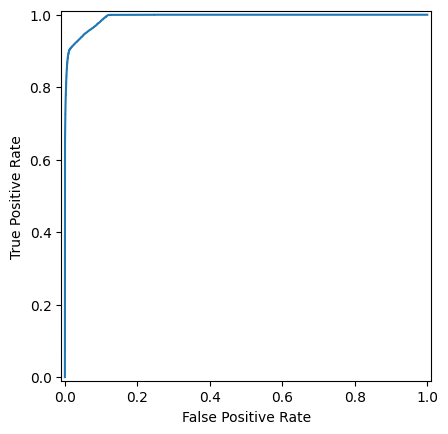

In [52]:
y_score = model.predict_proba(test_features)[:,1]

roc_auc = round(roc_auc_score(test_features_labels["is_laundering"], y_score), 4)
print("roc_auc_score =", roc_auc)
fpr, tpr, _ = roc_curve(test_features_labels["is_laundering"], y_score, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [53]:
%%time

CV_FOLD_PERC = 0.8
N_FOLDS = 5

f1_scores = []
for fold in range(N_FOLDS):
    print("Fold", fold + 1)
    x_train = train_features.sample(frac=CV_FOLD_PERC)
    x_train_labels = x_train.loc[:, []].join(train_features_labels, how="left")
    x_validation = validation_features.sample(frac=CV_FOLD_PERC)
    x_validation_labels = x_validation.loc[:, []].join(validation_features_labels, how="left")
    model_fold = train_model(
        x_train, x_train_labels["is_laundering"].values, 
        x_validation, x_validation_labels["is_laundering"].values,
        cv=True
    )
    y_test_predicted = model_fold.predict(test_features)
    f1_cv = f1_score(test_features_labels["is_laundering"], y_test_predicted) * 100
    print(
        round(f1_cv, 2),
        round(recall_score(test_features_labels["is_laundering"], y_test_predicted) * 100, 2)
    )
    f1_scores.append(f1_cv)

Fold 1
Best iteration: 98

71.04 62.64
Fold 2
Best iteration: 99

71.17 62.91
Fold 3
Best iteration: 99

70.96 62.87
Fold 4
Best iteration: 83

71.25 63.29
Fold 5
Best iteration: 99

71.05 62.95
CPU times: user 14h 32min 38s, sys: 4min 8s, total: 14h 36min 46s
Wall time: 1h 36min


In [58]:
gfp_best = 65.69
gfp_std = 0.26

In [59]:
print(f"GFP best: {gfp_best} ± {gfp_std}")

GFP best: 65.69 ± 0.26


In [60]:
print(f"{round(f1_final, 2)} ±{round(np.std(f1_scores), 2)}")

70.91 ±0.1


In [61]:
uplift = round(((f1_final - gfp_best) / gfp_best) * 100, 2)
print(f"Uplift of {uplift}%")

Uplift of 7.95%
